# 1. Capacity distribution for conventional generations



Get the data for conventional genrators.

Probability distribution (ProbDist)    Cumulative distribution (cumdis)     Expected energy output up to x (Eep), used for EEU calculation.


In [17]:

# from numpy import loadtxt
# lines = loadtxt("I_conv.txt", comments="#", delimiter=",", unpack=False)

convCap=0
meanCap=0
varCap =0

######   read data
ListofCap=[]
ListofAva=[]

text_file = open("GB_anonymised_conv.txt", "r")
# text_file = open("I_conv.txt", "r")

for line in text_file:
    if (len(line.split())>=3):
        ListofCap.append(float(line.split()[1]))
        ListofAva.append(float(line.split()[2]))

for i in range(len(ListofCap)):
    convCap += ListofCap[i]
    meanCap += ListofCap[i]*ListofAva[i]
    varCap  += ListofCap[i]**2*ListofAva[i]*(1-ListofAva[i])

sdCap = varCap**0.5
print("Total capacity", convCap)
print("Expected capacity", meanCap)
print("SD", sdCap)

#calculate probs

maxCap=int(convCap)+1
ProbDist=[1]+[0]*(maxCap)

largestCap=1

for i in range(len(ListofCap)):
#    print(int(ListofCap[i]))
    largestCap+= round(ListofCap[i])
    temp=ProbDist.copy()
    for j in range(largestCap+1):
        if(j-round(ListofCap[i])>=0):
            ProbDist[j] = temp[j]*(1-ListofAva[i])+temp[j-round(ListofCap[i])]*ListofAva[i]
        else:
            ProbDist[j] = temp[j]*(1-ListofAva[i])

print("Length of ProbDist",len(ProbDist))
print(sum(ProbDist))
# print(ProbDist)

# Cumulative distribution 
cumdis=[0]*(maxCap+1)
for i in range(len(cumdis)):
    cumdis[i]=cumdis[i-1]+ProbDist[i]
    
    
    
# Expected energy output

Eep=[0]*(maxCap+1)
for i in range(len(Eep)):
    Eep[i]=Eep[i-1]+i*ProbDist[i]

Total capacity 59930.0
Expected capacity 52236.06906528692
SD 1738.8681620785815
Length of ProbDist 59932
1.0000000000000002


Print the cumulative distribution in a txt file

In [18]:
#### wirte results in txt
f = open("Capacity Distribution.txt", "w")
f.write("Capacity  Probability  CumulativeProb \n")
for i in range(len(ProbDist)):
    f.write(str(i))
    f.write('  ')
    f.write(str(ProbDist[i]))
    f.write('  ')
    f.write(str(cumdis[i]))
    f.write('\n')
f.close()

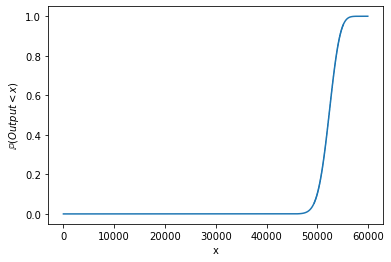

In [19]:
import math
import matplotlib.pyplot as plt

x=[]
for i in range(len(cumdis)):
    x.append(i)



plt.plot(x,cumdis)
#plt.title('cumulative probability distribution for conventional generators')
plt.xlabel('x')
plt.ylabel('$\mathbb{P}(Output<x)$')
plt.show()

# 2. LOLE, Loss of Load Expection

Read the data for GB demand 7(number of years)*demand each time; GB wind; Ir demand; Ir wind.

In [20]:
import numpy as np

GBdem=[]
GBwind=[]
Idem=[]
Iwind=[]

text_file = open("InterconnectionData_Rescaled.txt", "r")

for line in text_file:
#    if (str(line.split()[1]).startswith('"2008')):
    if (len(line.split())>=7):
        GBdem.append(float(line.split()[3]))
        GBwind.append(float(line.split()[5]))
        Idem.append(float(line.split()[4]))
        Iwind.append(float(line.split()[6]))

GBdem=np.array(GBdem)
GBwind=np.array(GBwind)
Idem=np.array(Idem)
Iwind=np.array(Iwind)

GBdem=GBdem.reshape(7,3360)
GBwind=GBwind.reshape(7,3360)


In [5]:
GBdem[0]

array([28372.72025732, 27053.93985423, 25711.9838577 , ...,
       36071.91980564, 33953.58142919, 32015.29958632])

Calculate the LOLE of each year.

In [21]:
LOLE_GB=[]
for y in range(7):
    LOLE=0
    for i in range(len(GBdem[0])):
        netdemand = GBdem[y][i]-GBwind[y][i]
        LOLP = cumdis[round(netdemand)]  #note: cumdis is the cumulative distribution calculated above
        LOLE += LOLP
    LOLE_GB.append(LOLE)

print('The LOLE each year 2007-2014 for GB are:  ')
print(LOLE_GB)


The LOLE each year 2007-2014 for GB are:  
[0.7303243658803696, 2.545702871381105, 2.7927996605889853, 8.043599051254958, 1.8922702234690605, 4.904167733963393, 0.09853091279546701]


Calculate the probability of no shortfall of each year.

In [22]:
Pnosf=[]
for y in range(7):
    P=1
    for i in range(len(GBdem[0])):
        netdemand = GBdem[y][i]-GBwind[y][i]
        P = P*(1-cumdis[round(netdemand)])  #note: cumdis is the cumulative distribution calculated above
    Pnosf.append(P)
print('The probability of no shortfall each year 2007-2014 for GB are:  ')
print(Pnosf)


The probability of no shortfall each year 2007-2014 for GB are:  
[0.47099563534517885, 0.0616097503123843, 0.04052613126351226, 4.216823824940439e-05, 0.11236394016313986, 0.00294394585467725, 0.9057516968090479]


Calculate the EEU of each year.
See below

# Calculate EFC value, using LOLE, time-collapsed

Let the sum of LOLE for theses 7 years be similar

In [23]:
EFC=2990.5    #Try EFC with value 700

LOLE_GB_EFC=[]
for y in range(7):
    LOLE=0
    for i in range(len(GBdem[0])):
        swtichdemand = GBdem[y][i]-EFC
        LOLP = cumdis[round(swtichdemand)]  #note: cumdis is the cumulative distribution calculated above
        LOLE += LOLP
    LOLE_GB_EFC.append(LOLE)

print('Assuming the EFC is: ',EFC, 'GW')
print('LOLE of 7 years for GB : ')
print(LOLE_GB)
print('sum',sum(LOLE_GB))
print('\n')
print('Using EFC :') 
print(LOLE_GB_EFC)
print('sum',sum(LOLE_GB_EFC))

Assuming the EFC is:  2990.5 GW
LOLE of 7 years for GB : 
[0.7303243658803696, 2.545702871381105, 2.7927996605889853, 8.043599051254958, 1.8922702234690605, 4.904167733963393, 0.09853091279546701]
sum 21.007394819333342


Using EFC :
[0.9467548769641602, 3.113059264571762, 4.4758117233476264, 7.035519091952702, 1.5292510505688657, 3.6668806506200378, 0.2370972571369944]
sum 21.004373915162148


Let the sum of EEU for theses 7 years be similar

# Calculate EFC value, using EEU, time-collapsed

Let the sum of EEU for theses 7 years be similar

In [29]:
EEU_GB=[]
for y in range(7):
    EEU=0
    for i in range(len(GBdem[0])):
        netdem = round(GBdem[y][i]-GBwind[y][i])
        EEUt =  netdem*cumdis[netdem-1]-Eep[netdem-1]
        EEU += EEUt
    EEU_GB.append(EEU)

print('The EEU each year 2007-2014 for GB are:  ')
print(EEU_GB)
print('The average EEU is: ',sum(EEU_GB)/len(EEU_GB))

The EEU each year 2007-2014 for GB are:  
[590.4953357331691, 2442.9190732008506, 2851.701949154869, 9782.879423519582, 2001.9718944348742, 5478.3981965444245, 64.94422744528916]
The average EEU is:  3316.18715714758


In [41]:
EFC=2806 #Try EFC with value 700

EEU_GB_EFC=[]
for y in range(7):
    EEU=0
    for i in range(len(GBdem[0])):
        x = round(GBdem[y][i]-EFC) #swtichdemand
        EEUt = x*cumdis[x-1]-Eep[x-1]
#        print(EEUt)
        EEU += EEUt
    EEU_GB_EFC.append(EEU)

print('EEU of 7 years for GB: ')
print(EEU_GB)
print('average',sum(EEU_GB)/len(EEU_GB))
print('\n')

print('Using EFC =',EFC, 'GW:') 
print(EEU_GB_EFC)
print('average',sum(EEU_GB_EFC)/len(EEU_GB_EFC))


EEU of 7 years for GB: 
[590.4953357331691, 2442.9190732008506, 2851.701949154869, 9782.879423519582, 2001.9718944348742, 5478.3981965444245, 64.94422744528916]
average 3316.18715714758


Using EFC = 2806 GW:
[935.9829377185706, 3292.556765873508, 5090.488062188333, 8325.026927016357, 1496.0752400113206, 3871.102919135179, 197.08292704214452]
average 3315.473682712201


# Calculate EFC value, using Prob of no shortfall, time collapsed


In [12]:
print('The average probability of no shortfall in year 2007-2014 for GB is:  ',sum(Pnosf)/7 )

EFC=3100 #Try EFC with value 700

Pnosf_EFC=[]
for y in range(7):
    P=1
    for i in range(len(GBdem[0])):
        x = round(GBdem[y][i]-EFC) #swtichdemand
        P = P*(1-cumdis[round(x)])  #note: cumdis is the cumulative distribution calculated above
    Pnosf_EFC.append(P)

print(Pnosf_EFC)
print('Using EFC= ', EFC,', The average probability of no shortfall in year 2007-2014 for GB is: ', sum(Pnosf_EFC)/7 )

The average probability of no shortfall in year 2007-2014 for GB is:   0.2277476097123128
[0.4262530973637139, 0.05533025249802788, 0.013018829818552983, 0.0009440530780991901, 0.2533442952396131, 0.0334748449094323, 0.817926356894541]
Using EFC=  3100 , The average probability of no shortfall in year 2007-2014 for GB is:  0.22861310425742576


# Substitute wind to n conventional generators


In [13]:
#### Construct new probability distribution
# n is the number of conventional generators added

n=36

ListofCap_copy=ListofCap.copy()
ListofAva_copy=ListofAva.copy()
ListofCap_copy.extend([100]*n)
ListofAva_copy.extend([0.95]*n)


for i in range(len(ListofCap_copy)):
    convCap += ListofCap_copy[i]
    
maxCap=int(convCap)+1
ProbDist_copy=[1]+[0]*(maxCap)

largestCap=1

for i in range(len(ListofCap_copy)):
#    print(int(ListofCap[i]))
    largestCap += round(ListofCap_copy[i])
    temp=ProbDist_copy.copy()
    for j in range(largestCap+1):
        if(j-round(ListofCap_copy[i])>=0):
            ProbDist_copy[j] = temp[j]*(1-ListofAva_copy[i])+temp[j-round(ListofCap_copy[i])]*ListofAva_copy[i]
        else:
            ProbDist_copy[j] = temp[j]*(1-ListofAva_copy[i])


print("Length of ProbDist",len(ProbDist))
print(sum(ProbDist))
# print(ProbDist)

Cumdis_copy=[0]*(maxCap+1)
for i in range(len(Cumdis_copy)):
    Cumdis_copy[i]=Cumdis_copy[i-1]+ProbDist_copy[i]


Length of ProbDist 59932
1.0000000000000002


In [14]:
### For each year:
### 2007
GBdem=[]
GBwind=[]
Idem=[]
Iwind=[]
######   read data
text_file = open("InterconnectionData_Rescaled.txt", "r")

for line in text_file:
    if (str(line.split()[1]).startswith('"2007')):
        GBdem.append(float(line.split()[3]))
        Idem.append(float(line.split()[4]))
        GBwind.append(float(line.split()[5]))
        Iwind.append(float(line.split()[6]))


LOLE_GB=0   #units is hours
for i in range(len(GBdem)):
    winminusdem = GBdem[i]-GBwind[i]   #netdemand
    LOLP = cumdis[round(winminusdem)]  #note: cumdis is the cumulative distribution calculated above
    LOLE_GB += LOLP
    
print('The LOLE for 2007 is:  ',LOLE_GB)


LOLE_GB=0   #units is hours
for i in range(len(GBdem)):
    demand = GBdem[i]
    LOLP = Cumdis_copy[round(demand)]  #note: cumdis is the cumulative distribution calculated above
    LOLE_GB += LOLP
print('The LOLE for 2007 is:  ',LOLE_GB)

The LOLE for 2007 is:   0.559241034163066
The LOLE for 2007 is:   0.5018562251239204


In [15]:
### For each year:
### 2018
GBdem=[]
GBwind=[]
Idem=[]
Iwind=[]
######   read data
text_file = open("InterconnectionData_Rescaled.txt", "r")

for line in text_file:
    if (str(line.split()[1]).startswith('"2008')):
        GBdem.append(float(line.split()[3]))
        Idem.append(float(line.split()[4]))
        GBwind.append(float(line.split()[5]))
        Iwind.append(float(line.split()[6]))


LOLE_GB=0   #units is hours
for i in range(len(GBdem)):
    winminusdem = GBdem[i]-GBwind[i]
    LOLP = cumdis[round(winminusdem)]  #note: cumdis is the cumulative distribution calculated above
    LOLE_GB += LOLP
    
print('The LOLE for 2008 is:  ',LOLE_GB)

LOLE_GB=0   #units is hours
for i in range(len(GBdem)):
    demand = GBdem[i]
    LOLP = Cumdis_copy[round(demand)]  #note: cumdis is the cumulative distribution calculated above
    LOLE_GB += LOLP
print('The LOLE for 2008 is:  ',LOLE_GB)


The LOLE for 2008 is:   0.8614741502843919
The LOLE for 2008 is:   0.8475928472192411


# Conclution
2007
LOLE with net demand is 0.5592

When n=35 LOLE=0.5611
When n=36 LOLE=0.5019

n therfore is approximately 35.2

2008
LOLE with net demand is 0.861

When n=35 LOLE=0.9501
When n=36 LOLE=0.8476

n therfore is approximately 35.8